In [16]:
import gym
import hiive.mdptoolbox, hiive.mdptoolbox.example, hiive.mdptoolbox.mdp
import hiive.mdptoolbox as mdptoolbox
import hiive.visualization
import numpy as np
import math
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
# can set the number of states

# 8x8
# from gym implementation
MAPS = {
    '4x4': ['SFFH',
            'FHFF',
            'FFFF',
            'HFFG'
    ],
    '8x8': ["SFFFFFFF",
            "FFFFFFFF",
            "FFFHFFFF",
            "FFFFFHFF",
            "FFFHFFFF",
            "FHHFFFHF",
            "FHFFHFHF",
            "FFFHFFFG"],
    '12x12': ['SFFFFHHFFHFF', 'FFFFFFFFFFFF', 'HFFFFFFFHHFF', 'FFFFFFFFHFFF', 
              'FFFFFFHHFFFH', 'HFFFFFFFFFFF', 'FFFFHFHFHHHH', 'FFFFFFFHFFFH', 
              'FFFFFFFHHHFF', 'FFFFFFHFFFFH', 'FFHFHFFFFFFF', 'FFFHFFFFHFFG'],
    '30x30':
    ['SFHHFHFFFFHFFFFFFFFFFFFFFFHHFF', 'HFHFFFFFFFFHFHFFFHFFFFFFFFFFFF', 
     'FFFFFFFFFFFHFHFHFHFFFHFHFFFFFF', 'FFFHFFFHFFFFFFFHHHHFFFFFFHFFFF', 
     'FFFHFFFFHFFFHFFFHFFHHFHHFFFHFH', 'FHFFHFFFFFFFFFHFFFHFHFHFFFFFFF', 
     'FFFHFFFHFFFFFFHHFFFFFFFFFFHFFH', 'FFFFFFFHFFFFFFFFFHFFFHFFHFFFFF', 
     'FFFFFFHFFFFFFFFFFHFFFFFFHFFFHF', 'HFFFFFHFFHFFHFFFHFFFFFFFFFFFFF', 
     'FFFFFHHFHFFFFHFFFFFFFFFFFFFFFF', 'FFFFFFFHFFHFFFHFFFHFFHFFFHFFFF', 
     'FFFFFFFFFHFFFFFHFFFFHHFFHFFFFF', 'FFFFFFFFFFFHFFFFFHFHFFFFFFFFFF', 
     'FFFFFFFHFHHFHFFFFHFHFFHFHFFFFH', 'HFFFFFHFHHFFHHFFHFFFFFHFFFFHFF', 
     'FFFHFHFHHFFFFFFHFFFFHFHFFFHFFF', 'FFFFFFHFFFFFFFFHFFFFHHHFHFFFFF', 
     'FFFFFFFFFFFFFFFFFFFFFFFFFFFFFF', 'HFFFFFHFFFFFFHFHFFHFFFHHFFFFFF', 
     'FFHFFFFFFFFFFFFFFHHFFFFFFFFFFF', 'HFFFFFFFFFFFHFFHFHHHFFHFFHFFFH', 
     'FFFFFFFFFFFHHFFFFFFHFHFHHFHFFF', 'HFFHFFFFHFFFHFFFHFFFFFFFFFFFFH', 
     'HFFFFFHFHHFFHFFHFFFHFFHFFFFFHF', 'FFFHFFHFFFFFFFFFFFFFFFFFFFFFFF', 
     'FFFFHFHFFFFHFFFFFFFFFFHFFFFFFF', 'FFFHFFHFFFFFFFFFFFFFFHFFFFHFFF', 
     'FFFFFFHHFFFFFFFFHFFFFFFFFFHFFF', 'HFHFFFFFFFHHFFFFFFFHHHFFHHFHFG']
        }

# order from ai gym for my sanity
actions = ['LEFT', 'DOWN', 'RIGHT', 'UP']
N_EPISODES = 1000

# Environment
# from https://gym.openai.com/docs/
# https://www.kaggle.com/angps95/intro-to-reinforcement-learning-with-openai-gym
curr_map = MAPS['8x8']
env = gym.make('FrozenLake-v0', desc=curr_map)
#env = gym.make('FrozenLake8x8-v0')

# Set up transition and rewards matrices
env.reset() # just to be sure we're at the start state in the grid world
n_size = env.nS
n_action = env.nA

# for visualization later
env_state = []
for r in curr_map:
    env_state.append(list(r))

# from MDP docs, use numpy array that has the shape (A, S, S) for reward and trans
trans = np.zeros((n_action, n_size, n_size))
reward = np.zeros((n_action, n_size, n_size))

for s, s_info in env.P.items():
    for a, a_info in s_info.items():
        for i, info in enumerate(a_info):
            p = info[0]
            s_prime = info[1]
            r = info[2]
            reward[a, s, s_prime] = r
            trans[a, s, s_prime] += p

[13, 13, 17, 13, 18, 24, 12, 20, 30, 40, 26, 45, 65, 85]
[0.334, 0.322, 0.483, 0.357, 0.48, 0.514, 0.085, 0.522, 0.546, 0.538, 0.558, 0.642, 0.579, 0.599]


<Figure size 432x288 with 0 Axes>

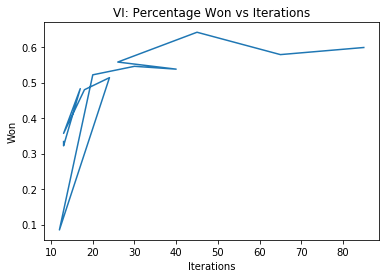

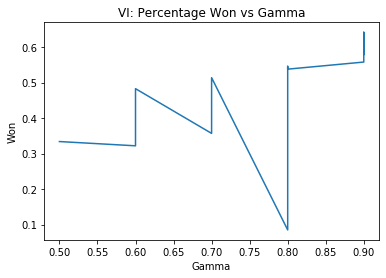

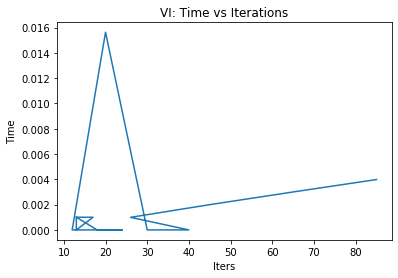

***BEST***
{'e': 0.001, 'd': 0.9, 'won': 0.642, 'moves': 37, 'iters': 45, 'time': 0.001997709274291992, 'policy': (3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 1, 3, 3, 0, 0, 2, 3, 2, 1, 3, 3, 3, 1, 0, 0, 2, 1, 3, 3, 0, 0, 2, 1, 3, 2, 0, 0, 0, 1, 3, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 2, 2, 1, 0, 0, 1, 1, 1, 0), 'value': (0.00551999310575215, 0.007673345066613621, 0.011457936538648655, 0.01699584148235821, 0.02434194824993963, 0.03174563576189433, 0.03887278015685188, 0.042293947141633564, 0.005132112114344364, 0.006765405536797916, 0.010060867921283608, 0.015630469720865126, 0.025355399841772725, 0.0355000363982948, 0.04869913047694825, 0.05667619356926911, 0.004218438114358632, 0.005005687531393303, 0.005992823712113207, 0.0, 0.024960733913996506, 0.03817494617665048, 0.06705377330655544, 0.08380663716505089, 0.003410150862681159, 0.0040036580911869315, 0.005182013997731932, 0.007491409309486494, 0.019917141906940626, 0.0, 0.09125045012780339, 0.128723895942196, 0.002467277214137087, 0.002

In [37]:
# Value Iteration

# hparams
# learning rate
discount = [0.1, .2, .3, .4, .5, .6, .7, .8, .9]

#stopping factor
epsilon = [.01, .001, .0001, .00001]
best_hparams = {'e': -1, 'd': -1, 'won': 0.0, 'moves': 0, 'iters': 0, 
                'time': 0.0, 'policy': None, 'value': None}

win_stats_by_episode = []
for d in discount:
    for e in epsilon:
        vi = mdptoolbox.mdp.ValueIteration(trans, reward, epsilon=e, gamma=d)
    
        vi.run()
        # returns moves, reward for each episode
        results = play_game(env, vi.policy)
        
        # only tracking won games in result
        if len(results) > 0:
            percent_won = len(results) / N_EPISODES
            moves_taken = math.floor(sum([r['moves'] for r in results]) / N_EPISODES)
        
            # overall episode stats
            win_stats_by_episode.append({'won': percent_won,'moves': moves_taken, 'iters': vi.iter,
                                     'time': vi.time,'policy': vi.policy, 'value': vi.V,
                                     'e': e,'d': d})
        
            if percent_won > best_hparams['won']:
                best_hparams['e'] = e
                best_hparams['d'] = d
                best_hparams['won'] = percent_won
                best_hparams['moves'] = moves_taken
                best_hparams['iters'] = vi.iter
                best_hparams['time'] = vi.time
                best_hparams['policy'] = vi.policy
                best_hparams['value'] = vi.V

visualize_policy(win_stats_by_episode, rl_type='VI')
visualize_stats(win_stats_by_episode, rl_type='VI')
            
print("***BEST***")
print(best_hparams)
            
# Play again with the best?

best_results = play_game(env, best_hparams['policy'])

#visualize_policy(best_results, 'VI')

#win_lose = Counter([r['reward'] for r in best_results])
#print((win_lose[1] / N_EPISODES) * 100)
print((len(best_results) / N_EPISODES) * 100)


            
    

***BEST***
{'d': 0.9, 'won': 0.581, 'moves': 34, 'iters': 8, 'time': 0.027580976486206055, 'policy': (3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 1, 3, 3, 0, 0, 2, 3, 2, 1, 3, 3, 3, 1, 0, 0, 2, 1, 3, 3, 0, 0, 2, 1, 3, 2, 0, 0, 0, 1, 3, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 2, 0, 1, 0, 0, 1, 1, 1, 0), 'value': (0.006411114261567695, 0.008548152348756928, 0.012300498232638213, 0.017789476934689144, 0.025082182967596324, 0.03247093431161943, 0.03957138135942697, 0.04297848493990471, 0.006024130646869564, 0.007645190581127953, 0.010911685608133354, 0.016426596546678347, 0.026054159279438664, 0.03619413203435169, 0.04935473823209154, 0.05730464658653961, 0.0050903171133021745, 0.005853275950835511, 0.006775412141688242, 0.0, 0.025570882596180875, 0.038821434237461344, 0.06763976616100523, 0.08435610380316755, 0.0042256837242051195, 0.0047696115765097705, 0.005819745579991939, 0.007854128215108456, 0.020360681803702912, 0.0, 0.09175504516809167, 0.12919114271305238, 0.0031810051723101624, 0.0031966

<Figure size 432x288 with 0 Axes>

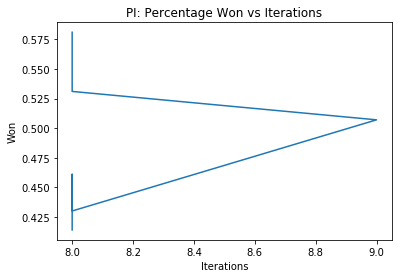

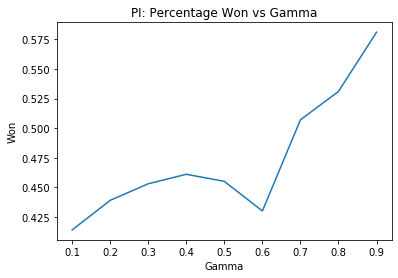

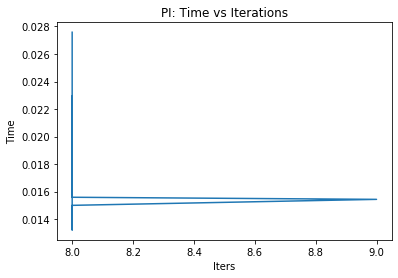

59.699999999999996


In [38]:
# Policy Iteration
# hparams
# learning rate
discount = [0.1, .2, .3, .4, .5, .6, .7, .8, .9]

best_hparams = {'d': -1, 'won': 0.0, 'moves': 0, 'iters': 0, 
                'time': 0.0, 'policy': None, 'value': None}

win_stats_by_episode = []
for d in discount:
    pi = mdptoolbox.mdp.PolicyIteration(trans, reward, gamma=d)

    pi.run()
    # returns moves, reward for each episode
    results = play_game(env, pi.policy)
    # only tracking won games in result
    if len(results) > 0:
        percent_won = len(results) / N_EPISODES
        moves_taken = math.floor(sum([r['moves'] for r in results]) / N_EPISODES)

        # overall episode stats
        win_stats_by_episode.append({'won': percent_won,'moves': moves_taken, 'iters': pi.iter,
                                         'time': pi.time,'policy': pi.policy, 'value': pi.V,'d': d})

        if percent_won > best_hparams['won']:
            best_hparams['d'] = d
            best_hparams['won'] = percent_won
            best_hparams['moves'] = moves_taken
            best_hparams['iters'] = pi.iter
            best_hparams['time'] = pi.time
            best_hparams['policy'] = pi.policy
            best_hparams['value'] = pi.V
            
print("***BEST***")
print(best_hparams)
visualize_policy(win_stats_by_episode, rl_type='PI')
visualize_stats(win_stats_by_episode, rl_type='PI')
            
# Play again with the best?
best_results = play_game(env, best_hparams['policy'])
#visualize_policy(best_results, 'Frozen PI Policy-Best', True, 'PI')

#win_lose = Counter([r['reward'] for r in best_results])
#print((win_lose[1] / N_EPISODES) * 100)
print((len(best_results) / N_EPISODES) * 100)

#V (tuple) – value function
#policy (tuple) – optimal policy
#iter (int) – number of done iterations
#time (float) – used CPU time

Discount0.1
Discount0.3
Discount0.5
Discount0.7
Discount0.9
***BEST***
{'d': 0.3, 'won': 0.031, 'moves': 1, 'ql_iters': 1000000, 'time': 49.886141300201416, 'policy': (1, 2, 3, 3, 2, 3, 2, 0, 3, 3, 1, 1, 2, 1, 2, 2, 2, 2, 0, 0, 2, 3, 3, 0, 3, 2, 2, 2, 0, 0, 3, 0, 2, 1, 0, 0, 3, 1, 2, 1, 0, 0, 0, 2, 2, 0, 0, 0, 3, 0, 1, 0, 0, 0, 0, 0, 2, 3, 0, 0, 2, 3, 3, 0), 'value': (8.561557588447748e-18, 4.551246576477109e-16, 1.258471827221625e-14, 3.84384985775733e-13, 1.6711142935274804e-11, 2.3411645515371166e-10, 5.39342685014339e-09, 2.655424876080676e-08, 3.6671735583483663e-17, 1.2941883836574687e-15, 4.150494436664642e-14, 1.7755127467210885e-12, 1.318414366249301e-10, 2.2516435278075178e-09, 3.816139091865777e-08, 2.972873324336045e-07, 4.1098173355478713e-19, 4.5197160309901794e-17, 2.0923198257972888e-15, 0.0, 6.961263752624286e-10, 1.4752953479714778e-08, 2.325119243772744e-07, 3.2866672742500427e-06, 5.541441181405909e-18, 6.837673384430226e-16, 7.470487532735606e-14, 5.899256274247961

<Figure size 432x288 with 0 Axes>

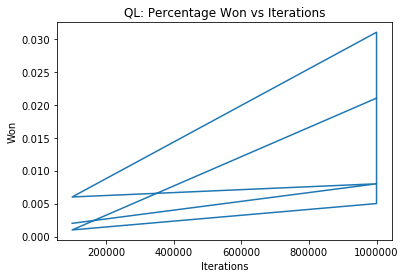

3.1


In [32]:
# QL

# hparams
# learning rate - fewer so ql finishes
discount = [.1, .3, .5, .7, .9]
# number of iterations...QL usually needs a lot to solve
iterations = [10000, 100000, 1000000]

best_hparams = {'d': -1, 'won': 0.0, 'moves': 0, 'ql_iters': 0, 
                'time': 0.0, 'policy': None, 'value': None, 'q': None}
win_stats_by_episode = []

for d in discount:
    print('Discount' + str(d))
    for it in iterations:
        ql = mdptoolbox.mdp.QLearning(trans, reward, gamma=d, n_iter=it)

        ql.run()
        # returns moves, reward for each episode
        results = play_game(env, ql.policy)
        
        # only tracking won games in result
        if len(results) > 0:

            percent_won = len(results) / N_EPISODES
            moves_taken = math.floor(sum([r['moves'] for r in results]) / N_EPISODES)

            # overall episode stats
            win_stats_by_episode.append({'won': percent_won,'moves': moves_taken, 'iters': it,
                                         'time': ql.time,'policy': ql.policy, 'value': ql.V,'d': d,
                                        'q': ql.Q })
            if percent_won > best_hparams['won']:
                best_hparams['d'] = d
                best_hparams['won'] = percent_won
                best_hparams['moves'] = moves_taken
                best_hparams['ql_iters'] = it
                best_hparams['time'] = ql.time
                best_hparams['policy'] = ql.policy
                best_hparams['value'] = ql.V
                best_hparams['q'] = ql.Q

print("***BEST***")
print(best_hparams)
visualize_policy(win_stats_by_episode, rl_type='QL')
visualize_stats(win_stats_by_episode, rl_type='QL')
            
# Play again with the best?
best_results = play_game(env, best_hparams['policy'])
#visualize_policy(best_results, 'Frozen QL Policy-Best', True, 'QL')

#win_lose = Counter([r['reward'] for r in best_results])
#print((win_lose[1] / N_EPISODES) * 100)
print((len(best_results) / N_EPISODES) * 100)

#V (tuple) – value function
#policy (tuple) – optimal policy
#iter (int) – number of done iterations
#time (float) – used CPU time

In [4]:
def play_game(env, policy):
    policy = np.asarray(policy)
    episode_results = []
    for i_episode in range(N_EPISODES):
        state = env.reset() # reset state to s0.
        moves = 0
        done = False
        while not done:
            action = policy[state]
            state, reward, done, info = env.step(action)
            moves += 1
            if done:
                if reward == 1.0:
                    episode_results.append({'moves': moves})
                break
        env.close()
    return episode_results

In [3]:
# this is only stats by winning episode
def visualize_policy(stats_by_episode, rl_type=''):
    # VI stats {'won': percent_won,'moves': moves_taken, 'iters': vi.iter,
    # 'time': vi.time,'policy': vi.policy, 'value': vi.V, 'e': e,'d': d}
    
    action_taken = {0: '<', 1: 'v', 2: '>', 3: '^'}
    
    # policy for each win.
    dim = int(np.sqrt(n_size))
    state_arr = (dim, dim)
    
    for stat in stats_by_episode:
        # reshape tuple as array
        policy = np.reshape(stat['policy'], state_arr)
        policy_labels = np.vectorize(action_taken.get)(policy)
        # add the state labels
        temp = []
        for x, y in np.nditer([policy_labels,env_state]):
            x = ' - '.join([str(y), str(x)])
            temp.append(x)
        policy_labels = np.reshape(temp, state_arr)
        plot = sns.heatmap(policy,
                          annot=policy_labels, fmt='', linewidth=.6)
        title = f'Frozen Lake {rl_type} Policy-Iteration {stat["iters"]} ' 
        plot.title.set_text(title)
        fig = plot.get_figure()
        fig.savefig('../images/' + rl_type.lower() + '_frozen/policy_frozen_it_' + rl_type + '_' + str(stat["iters"]) + '.png')
        fig.clf()
        

In [39]:
# TODO These graphs need a lot of work
def visualize_stats(stats_by_episode, rl_type=''):
    # VI stats {'won': percent_won,'moves': moves_taken, 'iters': vi.iter,
    # 'time': vi.time,'policy': vi.policy, 'value': vi.V, 'e': e,'d': d}
    # PI stats
    # {'won': percent_won,'moves': moves_taken, 'iters': pi.iter,
    # 'time': pi.time,'policy': pi.policy, 'value': pi.V,'d': d})
    # QL stats
    #  ({'won': percent_won,'moves': moves_taken, 'iters': it,
    #    'time': ql.time,'policy': ql.policy, 'value': ql.V,'d': d,
    #'q': ql.Q })
    # list of iterations
    iters = [s['iters'] for s in stats_by_episode]
    print(iters)
    won = [s['won'] for s in stats_by_episode]
    gamma = [s['d'] for s in stats_by_episode]
    time = [s['time'] for s in stats_by_episode]
    print(won)
    
    # percent won
    plt.figure()
    plt.plot(iters, won)
    plt.xlabel('Iterations')
    plt.ylabel('Won')
    plt.title(f'{rl_type}: Percentage Won vs Iterations')
    plt.savefig('../images/' + rl_type.lower() + '_frozen/iter_vs_won_' + rl_type + '_.png')
    plt.show()

    # gamma vs won
    plt.figure()
    plt.plot(gamma, won)
    plt.xlabel('Gamma')
    plt.ylabel('Won')
    plt.title(f'{rl_type}: Percentage Won vs Gamma')
    plt.savefig('../images/' + rl_type.lower() + '_frozen/gamma_vs_won_' + rl_type + '_.png')
    plt.show()
    
    # time vs iterations
    
        # gamma vs won
    plt.figure()
    plt.plot(iters, time)
    plt.xlabel('Iters')
    plt.ylabel('Time')
    plt.title(f'{rl_type}: Time vs Iterations')
    plt.savefig('../images/' + rl_type.lower() + '_frozen/time_vs_iters_' + rl_type + '_.png')
    plt.show()
    

In [ ]:
# Taken as is from https://github.com/openai/gym/blob/master/gym/envs/toy_text/frozen_lake.py
def generate_random_map(size=8, p=0.8):
    """Generates a random valid map (one that has a path from start to goal)
    :param size: size of each side of the grid
    :param p: probability that a tile is frozen
    """
    valid = False

    # DFS to check that it's a valid path.
    def is_valid(res):
        frontier, discovered = [], set()
        frontier.append((0,0))
        while frontier:
            r, c = frontier.pop()
            if not (r,c) in discovered:
                discovered.add((r,c))
                directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]
                for x, y in directions:
                    r_new = r + x
                    c_new = c + y
                    if r_new < 0 or r_new >= size or c_new < 0 or c_new >= size:
                        continue
                    if res[r_new][c_new] == 'G':
                        return True
                    if (res[r_new][c_new] not in '#H'):
                        frontier.append((r_new, c_new))
        return False

    while not valid:
        p = min(1, p)
        res = np.random.choice(['F', 'H'], (size, size), p=[p, 1-p])
        res[0][0] = 'S'
        res[-1][-1] = 'G'
        valid = is_valid(res)
    return ["".join(x) for x in res]


In [ ]:
# Used to initially generate constant maps 
m = generate_random_map(size=30)
print(m)